### Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy import optimize

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from traitlets.config.loader import Config
from astropy.coordinates     import SkyCoord
from lstchain.io.config      import get_standard_config
from ctapipe.io              import read_table
import tables

# Other auxiliar scripts
sys.path.insert(0, os.getcwd() + "/../scripts/")
import auxiliar as aux
import geometry as geom
import lstpipeline
import plotting

import logging
logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

# Some configurations

In [2]:
""" Source name in order to just complete the results file, and
in order to improve run organization."""
source_name = "crab"

""" The run number that we are interested in apply the corrections.
The process is done run-wise, so the input will be an individual run."""
run_number  = 6172
srun_number = 0 

""" Fit parameters
Chosen limits in intensity (p.e.) for applying the fit i.e. the
power law will be fitted only with the points within this range."""
limits_intensity = [316, 562]
""" For the positive scaling cases (most of them), we need to have a lower 
limit in intensity. Thi slimit is used for the subset of events that are 
scaled just to find which is the scaling value. We use a very low limit by
default 60 p.e. compared to the lower limit of the fit 316 p.e. because in 
the worst cases we will have a very non-linear scaling that will displace 
significantly the events intensities."""
limits_intensity_extended = 60

""" Power law parameters for the reference
All these parameters are taken from a common analysis of the full dataset
Where the period of end of 2022 and start 2023 is taken as reference for good 
runs. Then we take as reference the mean power law parameters in that period.
p0 is the normalization factor and p1 is the slope."""
ref_p0 =  1.74 
ref_p1 = -2.23

""" Threshold in statistics for the last subrun
The limit in number of events after cleaning that we need to consider the last
subrun has enough statistics to perform the analysis over it. Otherwise the 
values of the scaling that will be applied to this last rubrun are the same 
that are applied to the last last subrun."""
statistics_threshold_last_srun = 15000

""" Parameters for the empyrical fits for Zenith Distance corrections
Are simply two 2 degree polynomials for each variable of the power law."""
p0a, p0b, p0c = -0.44751321, 3.62502037, -1.43611437
p1a, p1b, p1c = -2.89253919, 0.99443581, -0.34013068

""" Empty dictionary to store all the results of one run."""
dict_results_empty = { 
    "run": run_number, "filenames": {}, "statistics": {},
    "scaled" :           {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "p0":                {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "delta_p0":          {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "p1":                {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "delta_p1":          {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "chi2":              {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "pvalue":            {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "light_yield":       {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "delta_light_yield": {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "scaling":           {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "delta_scaling":     {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "scaling_percent":       {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "delta_scaling_percent": {"original": {}, "upper": {}, "linear": {}, "final": {}},
    "final_scaling": {}, "final_scaling_interpolated": {}, "interpolation" : {},
}

# Paths to data and results

In [3]:
# Root path of this script
root = os.getcwd() + "/"
# Path to store the configuration file we are going to use
config_file = root + "config/standard_config.json"
# Path to store objects
root_objects = root + f"objects/"
# Data main directory
root_data = root + f"../../data/cherenkov_transparency_corrections/{source_name}/"
# Directory for the results of the fit of each run
root_results = root_objects + "results_fits/"

# STANDARD paths ---------
root_dl1 = "/fefs/aswg/data/real/DL1/*/v0.*/tailcut84/"
root_rfs = "/fefs/aswg/data/models/AllSky/20230901_v0.10.4_allsky_base_prod/"
root_mcs = "/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/"

# Create the paths that do not exist
for path in [os.path.dirname(config_file), root_objects, root_results]:
    if not os.path.exists(path):
        os.makedirs(os.path.join(path), exist_ok=True)

# Opening and storing configuration file

In [4]:
dict_config = get_standard_config()

# We select the heuristic flatfield option in the standard configuration
dict_config["source_config"]["LSTEventSource"]["use_flatfield_heuristic"] = True

with open(config_file, "w") as json_file:
    json.dump(dict_config, json_file)

# Finding the files that interest us
#### Extracting dl1 files and dl1 datachecks

In [5]:
%%time
# Getting coordinates of source
source_coords = SkyCoord.from_name(source_name)

dict_source = {
    "name"   : source_name,
    "coords" : source_coords,
    "ra"     : source_coords.ra.deg  * u.deg, # ra in degrees
    "dec"    : source_coords.dec.deg * u.deg, # dec in degrees
}

# We create a empty dictionary to store all the information needed inside
dict_dchecks = {}
for run in [run_number]:
    dict_dchecks[run] = {
        "run_num" : run,
    }

dict_dchecks = lstpipeline.add_dl1_paths_to_dict(dict_dchecks, root_dl1)
dict_dchecks = lstpipeline.add_dl1_paths_to_dict(dict_dchecks, root_dl1, dchecking=True)


Adding dl1  data to dictionary...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary...
...Finished adding dl1 data to dictionary


CPU times: user 12.8 s, sys: 7.14 s, total: 19.9 s
Wall time: 30.9 s


#### Then we read the observations information and also the selected nodes for MC and RFs and we add it to the DICT

In [6]:
tab_dcheck_run = read_table(dict_dchecks[run_number]["dchecks"]["runwise"], "/dl1datacheck/cosmics")

# reading the variables
dcheck_zd = 90 - np.rad2deg(np.array(tab_dcheck_run["mean_alt_tel"]))
dcheck_az = np.rad2deg(np.array(tab_dcheck_run["mean_az_tel"]))
dcheck_tstart   = tab_dcheck_run["dragon_time"][0][0]
dcheck_telapsed = np.array(tab_dcheck_run["elapsed_time"])

dict_dchecks[run_number]["time"] = {
    "tstart"   : dcheck_tstart,            # datetime object
    "telapsed" : np.sum(dcheck_telapsed),  # s
    "srunwise" : {
        "telapsed" : dcheck_telapsed,      # s      
    },
}
dict_dchecks[run_number]["pointing"] = {
    "zd" : np.mean(dcheck_zd),  # deg
    "az" : np.mean(dcheck_az),  # deg
    "srunwise" : {
        "zd" : dcheck_zd, # deg
        "az" : dcheck_az, # deg
    },
}
    
# then we also select the RFs and MC files looking at the nodes available
dict_dchecks, dict_nodes = lstpipeline.add_mc_and_rfs_nodes(dict_dchecks, root_rfs, root_mcs, dict_source)

### Read datacheck
#### - The binning

In [7]:
ref_intensity = (limits_intensity[0] * limits_intensity[1]) ** 0.5
logger.info(f"The intensity in the middle of the intensity range is {ref_intensity:.1f} p.e.")

########################################################
# Reading the binning from the datacheck ---------------
# Opening the corresponding datacheck
fname_dcheck = dict_dchecks[run_number]["dchecks"]["runwise"]
tab_dcheck_run = tables.open_file(fname_dcheck)

# Read the binning from the datacheck of the first subrun
dcheck_intensity_binning = np.array(tab_dcheck_run.root.dl1datacheck.histogram_binning.col("hist_intensity")[0])
# Calculating the logarithmic center of each bin
dcheck_intensity_binning_centers = (dcheck_intensity_binning[:-1] * dcheck_intensity_binning[1:]) ** 0.5
# Calculating the width of each bin
dcheck_intensity_binning_widths = np.diff(dcheck_intensity_binning)
tab_dcheck_run.close()

# Mask for the fitting region in the fits
mask_dcheck_bins_fit = (
    (dcheck_intensity_binning_centers >= limits_intensity[0]) &
    (dcheck_intensity_binning_centers <= limits_intensity[1])
)

The intensity in the middle of the intensity range is 421.4 p.e.


#### - The intensity data from the datacheck

In [8]:
##########################################################
# Reading the histogram from the datacheck ---------------
# Opening the corresponding datacheck
tab_dcheck_run = tables.open_file(fname_dcheck)
dcheck_hist_intensities = np.array(tab_dcheck_run.root.dl1datacheck.cosmics.col("hist_intensity"))
tab_dcheck_run.close()

# Converting from counts to rate per intensity unit (non-binning dependent quantity)
dcheck_rates       = [] # Array of histogram of rates for each subrun
dcheck_delta_rates = [] # The statistical error
for srun, dcheck_hist_intensity in enumerate(dcheck_hist_intensities):

    effective_time_srun = dict_dchecks[run_number]["time"]["srunwise"]["telapsed"][srun]
    
    dcheck_rates.append(              dcheck_hist_intensity  / effective_time_srun / dcheck_intensity_binning_widths)

    dcheck_delta_rates.append(np.sqrt(dcheck_hist_intensity) / effective_time_srun / dcheck_intensity_binning_widths)
    
# Number of events in last subrun
last_subrun_statistics = np.sum(dcheck_hist_intensities[-1])

# Subruns array 
sruns_array = np.sort([int(f[-7:-3]) for f in dict_dchecks[run_number]["dl1a"]["srunwise"]])

### Correction factors

In [9]:
corr_factor_p0 = geom.pol2(1, p0a, p0b, p0c) / geom.pol2(np.cos(np.deg2rad(dict_dchecks[run_number]["pointing"]["zd"])), p0a, p0b, p0c)
corr_factor_p1 = geom.pol2(1, p1a, p1b, p1c) - geom.pol2(np.cos(np.deg2rad(dict_dchecks[run_number]["pointing"]["zd"])), p1a, p1b, p1c)

# Zenith correction of the reference (putting the reference in the zenith of the determined subrun)
corr_ref_p0 = ref_p0 / corr_factor_p0
corr_ref_p1 = ref_p1 - corr_factor_p1

## Function to perform all the scaling and then the reading
#### - Zenith corrections and light yield

Taking into account the logarithmic scale that is used, the light yield can be calculated with the following expression:\
\
$\qquad\qquad LY(A_{fit}, \alpha; A_{ref}) = \left(\frac{A_{fit}}{A_{ref}}\right)^{-\frac{1}{1+\alpha}}$\
\
The uncertainties have been calculated propagating the known ones.\
$\sigma_{LY} = \sqrt{\sum_x\left(\frac{\partial LY}{\partial x}\right)^2 \sigma_x^2}$\
Where:\
$\left(\frac{\partial LY}{\partial A}\right) =\left(\frac{A_{fit}}{A_{ref}}\right)^{-\frac{1}{1+\alpha}} \dfrac{-1}{\left({\alpha}+1\right)A_{fit}}$\
$\left(\frac{\partial LY}{\partial \alpha}\right) = \ln \left(\frac{A_{fit}}{A_{ref}}\right) \left(\frac{A_{fit}}{A_{ref}}\right)^{-\frac{1}{1+\alpha}} \frac{1}{(1+\alpha)^2}$\
\
So the final error will be:
\
$\sigma_{LY} = \left(\frac{A_{fit}}{A_{ref}}\right)^{-\frac{1}{1+\alpha}} \frac{1}{1+\alpha}\sqrt{A_{fit}^{-2}\sigma_{A}^2+\ln\left(\frac{A_{fit}}{A_{ref}}\right)^2\frac{\sigma_{\alpha}^2}{(1+\alpha)^2}}$

#### - Defining scaling
In order to sample we will set two scalings for the conversion.

* $1/LY$ The ideal scaling needed. The case where no new pixels emerge on the cleaning (unrealistic).

And the error is calculated now as:
\
$\sigma_{s} = \frac{1}{LY^4}\sigma_{LY}$

In [10]:
def find_scaling(iteration_step, dict_results):
    """
    A function to perform scaling and evaluating the results. Returning everything in a updated dictionary

    Input:
    - iteration_step: (str) 
        The iteration step you are in, that can be "original" for the original data, "upper" for the upper
        limit on the scale factor, "linear" for the linear intepolation factor and "final" for the final scaling 
        and results.
    - dict_results: (dict)
        Dictionary with the results of the before step.
    """

    # Creating a arrray of subruns looking at the datachecks and also extracting the run number
    run_number  = dict_results["run"]
    sruns_array = np.sort([int(f[-7:-3]) for f in dict_dchecks[run_number]["dl1a"]["srunwise"]])
    
    # Empty arrays to store the fit information
    data_p0, data_delta_p0  = [], []
    data_p1, data_delta_p1  = [], []
    data_chi2, data_pvalue  = [], []
    
    # Processing subrun by subrun
    for srun in [srun_number]:    

        input_fname = dict_dchecks[run_number]["dl1a"]["srunwise"][srun]   # Input dl1a        
        data_scale_factor = dict_results["scaled"][iteration_step][srun]   # Reading the scaling factor

        # Here we do different things depending on the iteration step
        # If is the first one i.e. == "original"
        # We do not run lstchain_dl1ab because the data is already scaled
        if iteration_step == "original":
            data_output_fname = input_fname

        # If is the second or third: "upper" or "linear"
        # We perform lstchain_dl1ab but over a subset of the data only to keep it shorter
        elif iteration_step in ["upper", "linear"]:

            # Temporal dl1 file that will be overwritten in the next iteration / subrun
            data_output_fname = root_objects + f"tmp_dl1_srunwise_{iteration_step}_scaled.h5" 

            logger.info(f"\nProcessing subrun {srun}")
            logger.info(f"Running lstchain_dl1ab... scale: {data_scale_factor:.2f}")

            # If scale is greater than 1 we select a range lower than the upper one
            # otherwise we select a range higher than the upper one
            if data_scale_factor > 1:
                dl1_selected_range = f"{limits_intensity_extended:.2f},{limits_intensity[1]:.2f}"
            else:
                dl1_selected_range = f"{limits_intensity[0]:.2f},inf"
                
            # # If the file already exists we delete it
            # if os.path.exists(data_output_fname):
            #     os.remove(data_output_fname)
        
            # !lstchain_dl1ab \
            # --input-file $input_fname \
            # --output-file $data_output_fname \
            # --config $config_file \
            # --no-image \
            # --light-scaling $data_scale_factor \
            # --intensity-range $dl1_selected_range

        # If is the last step i.e. "final"
        # The lstchain_dl1ab script is run over all thedataset to generate the final file
        elif iteration_step == "final":

            data_output_fname = root_data + f"dl1_scaled/{run_number:05}/" + os.path.basename(dict_dchecks[run_number]["dl1a"]["srunwise"][srun])
            logger.info(f"\nProcessing subrun {srun}")
            logger.info(f"Running lstchain_dl1ab... scale: {data_scale_factor:.2f}")
                
            # # If the file already exists we delete it
            # if os.path.exists(data_output_fname):
            #     os.remove(data_output_fname)
        
            # !lstchain_dl1ab \
            # --input-file $input_fname \
            # --output-file $data_output_fname \
            # --config $config_file \
            # --no-image \
            # --light-scaling $data_scale_factor

            # We store this info also in the dictionary in the final case
            dict_results["filenames"][srun] = data_output_fname
    
        # Reading the file
        # table_data = tables.open_file(data_output_fname)
        # data_counts_intensity, _ = np.histogram(
        #     table_data.root.dl1.event.telescope.parameters.LST_LSTCam.col("intensity"), 
        #     bins=dcheck_intensity_binning
        # )
        # table_data.close()
        data_counts_intensity = dcheck_hist_intensities[0] + np.random.rand(100) * 100
        
        # Calculating the non binning dependent transformation
        effective_time_srun = dict_dchecks[run_number]["time"]["srunwise"]["telapsed"][srun]
        data_rates       = np.array(data_counts_intensity) / effective_time_srun / dcheck_intensity_binning_widths
        data_delta_rates = np.sqrt(data_counts_intensity)  / effective_time_srun / dcheck_intensity_binning_widths
    
        # Displacing the X-coordinates to the center of the fit, in order to decorrelate the fit
        x_fit    = dcheck_intensity_binning_centers[mask_dcheck_bins_fit] / ref_intensity
        y_fit    = data_rates[mask_dcheck_bins_fit]
        yerr_fit = data_delta_rates[mask_dcheck_bins_fit]
    
        # Performing the fit
        params, pcov, info, _, _ = curve_fit(
            f     = geom.powerlaw,
            xdata = x_fit,
            ydata = y_fit,
            sigma = yerr_fit,
            p0    = [ref_p0, ref_p1],
            full_output = True,
        )
    
        srun_p0, srun_p1  = params
        srun_delta_p0 = np.sqrt(pcov[0, 0])
        srun_delta_p1 = np.sqrt(pcov[1, 1])
        srun_chi2     = np.sum(info["fvec"] ** 2)
        srun_pvalue   = 1 - chi2.cdf(srun_chi2, sum(mask_dcheck_bins_fit))
        
        dict_results["chi2"][iteration_step][srun]   = srun_chi2
        dict_results["pvalue"][iteration_step][srun] = srun_pvalue
        dict_results["scaled"][iteration_step][srun] = data_scale_factor
    
        data_p0.append(srun_p0)
        data_p1.append(srun_p1)
        data_delta_p0.append(srun_delta_p0)
        data_delta_p1.append(srun_delta_p1)
        data_chi2.append(srun_chi2)
        data_pvalue.append(srun_pvalue)
    
    # Convert to numpy arrays
    data_p0       = np.array(data_p0)
    data_p1       = np.array(data_p1)
    data_delta_p0 = np.array(data_delta_p0)
    data_delta_p1 = np.array(data_delta_p1)
    data_chi2     = np.array(data_chi2)
    data_pvalue   = np.array(data_pvalue)
    
    # Zenith corrections to the parameters
    data_corr_p0 = data_p0 * corr_factor_p0
    data_corr_p1 = data_p1 + corr_factor_p1
    
    data_corr_delta_p0 = data_delta_p0 * corr_factor_p0
    data_corr_delta_p1 = data_delta_p1
    
    # Calculating the needed light yield  
    data_light_yield, data_delta_light_yield = geom.calc_light_yield(
        p0_fit = data_corr_p0,
        p1_fit = data_corr_p1, 
        sigma_p0_fit = data_corr_delta_p0, 
        sigma_p1_fit = data_corr_delta_p1, 
        p0_ref = ref_p0,
    )
    
    # Scalings to apply
    data_scaling       = 1 / data_light_yield
    data_delta_scaling = 1 / data_light_yield ** 4 * data_delta_light_yield
    
    # In the case of the last subrun we use the last subrun statistics, because the lack of statistics
    if last_subrun_statistics < statistics_threshold_last_srun:
        data_scaling[-1]       = data_scaling[-2]
        data_delta_scaling[-1] = data_delta_scaling[-2]
    
        logger.warning(f"For last subrun using before subrun because of low statistics ({last_subrun_statistics}evs)\n")
    
    # The scaling in percentage
    data_scaling_percent       = (data_scaling - 1) * 100
    data_delta_scaling_percent = data_delta_scaling * 100
    
    # Adding to dictionary
    for i, srun in enumerate([srun_number]):
        dict_results["p0"][iteration_step][srun]       = data_corr_p0[i]
        dict_results["delta_p0"][iteration_step][srun] = data_corr_delta_p0[i]
        dict_results["p1"][iteration_step][srun]       = data_corr_p1[i]
        dict_results["delta_p1"][iteration_step][srun] = data_corr_delta_p1[i]
        
        dict_results["light_yield"][iteration_step][srun]       = data_light_yield[i]
        dict_results["delta_light_yield"][iteration_step][srun] = data_delta_light_yield[i]
        dict_results["scaling"][iteration_step][srun]           = data_scaling[i]
        dict_results["delta_scaling"][iteration_step][srun]     = data_delta_scaling[i]
        dict_results["scaling_percent"][iteration_step][srun]   = data_scaling_percent[i]
        dict_results["delta_scaling_percent"][iteration_step][srun] = data_delta_scaling_percent[i]

    return dict_results

### Applying the function over the original data

In [13]:
%%time
# The main results dictionary
dict_results = dict_results_empty.copy()
# First filling the dictionary with ones in the scaled values
for srun in [srun_number]:
    dict_results["scaled"]["original"][srun] = 1.0
    dict_results["statistics"][srun] = int(np.sum(dcheck_hist_intensities[srun]))

# Then we read these files and perform the fits
dict_results = find_scaling(iteration_step="original", dict_results=dict_results)

# Then filling the next step "scaled" with the calculated one
for srun in [srun_number]:
    dict_results["scaled"]["upper"][srun] = dict_results["scaling"]["original"][srun]

CPU times: user 2.52 ms, sys: 6.39 ms, total: 8.91 ms
Wall time: 7.18 ms


### Performing the first scaling for first run

In [16]:
%%time
dict_results = find_scaling(iteration_step="upper", dict_results=dict_results)


Processing subrun 0
Running lstchain_dl1ab... scale: 1.37


CPU times: user 4.78 ms, sys: 9.9 ms, total: 14.7 ms
Wall time: 11.1 ms


### Performing linear interpolation to calculate the new scaling factor

In [17]:
linear_scale_factors = []
for srun in [srun_number]:

    # In the case of the last subrun we use the last subrun statistics, because the lack of statistics
    if srun == sruns_array[-1] and last_subrun_statistics < statistics_threshold_last_srun:
        linear_scale_factor = linear_scale_factor

        logger.warning(f"For last subrun using before subrun because of low statistics ({last_subrun_statistics}evs)")
    else:
        # Now putting all together, upper and half
        points_scaling     = np.array([1, dict_results["scaling"]["original"][srun]])
        points_light_yield = np.array([dict_results["light_yield"]["original"][srun], dict_results["light_yield"]["upper"][srun]])
    
        # Finding the final scaling as a line that pass trogh the two points we have
        # Then we calculate where the light yield will be 1 in linear approximation
        slope = (points_light_yield[1] - points_light_yield[0]) / (points_scaling[1] - points_scaling[0])
        intercept = points_light_yield[0] - slope * points_scaling[0]
        linear_scale_factor = 1 / slope - points_light_yield[0] / slope + points_scaling[0]

    dict_results["scaled"]["linear"][srun] = linear_scale_factor
    linear_scale_factors.append(linear_scale_factor)

### Applying the linear factor to the data and then re-calculating the parameters

In [18]:
%%time
dict_results = find_scaling(iteration_step="linear", dict_results=dict_results)


Processing subrun 0
Running lstchain_dl1ab... scale: -41.98


CPU times: user 3.82 ms, sys: 12.2 ms, total: 16 ms
Wall time: 11.9 ms


In [19]:
dict_results

{'run': 6172,
 'filenames': {},
 'statistics': {0: 27748},
 'scaled': {'original': {0: 1.0},
  'upper': {0: 1.3686847602561871},
  'linear': {0: -41.980092131639836},
  'final': {}},
 'p0': {'original': {0: 1.1695654888039166},
  'upper': {0: 1.1875808480177672},
  'linear': {0: 1.1943022095636664},
  'final': {}},
 'delta_p0': {'original': {0: 0.030689182946517138},
  'upper': {0: 0.059558690964855276},
  'linear': {0: 0.029680356770870626},
  'final': {}},
 'p1': {'original': {0: -2.2657399854099776},
  'upper': {0: -2.2048746572082374},
  'linear': {0: -2.2084371468275665},
  'final': {}},
 'delta_p1': {'original': {0: 0.162381914764507},
  'upper': {0: 0.3093159126880095},
  'linear': {0: 0.1509991183176633},
  'final': {}},
 'chi2': {'original': {0: 4.576108478233326},
  'upper': {0: 17.014845329117318},
  'linear': {0: 4.206371873741968},
  'final': {}},
 'pvalue': {'original': {0: 0.469765412119971},
  'upper': {0: 0.004471728287787302},
  'linear': {0: 0.5201022368537684},
  'f

### Then calculate the final light yield and scaling

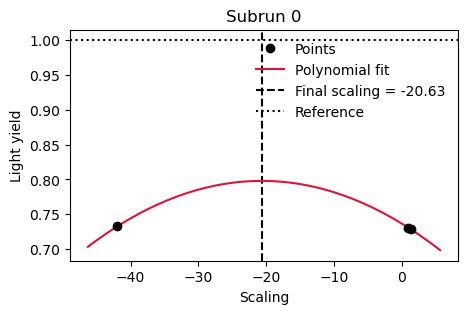

In [20]:
final_scale_factors = []
for srun in [srun_number]:

    # Now putting all together, upper and half
    points_scaling           = np.array([dict_results["scaled"][key][srun]            for key in ["original", "linear", "upper"]])
    points_light_yield       = np.array([dict_results["light_yield"][key][srun]       for key in ["original", "linear", "upper"]])
    points_delta_light_yield = np.array([dict_results["delta_light_yield"][key][srun] for key in ["original", "linear", "upper"]]) 
    
    # And fitting to a 2nd degree polynomial
    pol2_scaling = np.poly1d(np.polyfit(points_scaling, points_light_yield, 2))

    # And finding the final scaling
    final_scale_factor = optimize.root(pol2_scaling - 1, x0=linear_scale_factor).x[0]

    ############################################
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    ax.plot(points_scaling, points_light_yield, "o", color="k", label="Points", zorder=10)
    size_points = max(points_scaling) - min(points_scaling)

    ax.plot([points_scaling[0], points_scaling[2]], [points_light_yield[0], points_light_yield[2]], 
        marker="", ls="--", lw=0.5, color="k", label="", zorder=10)

    sample_scaling = np.linspace(min(points_scaling) - 0.1 * size_points, max(points_scaling) + 0.1 * size_points, 100)
    ax.plot(sample_scaling, pol2_scaling(sample_scaling), color="crimson", ls="-", label="Polynomial fit", zorder=5)
    ax.axvline(final_scale_factor, color="k", ls="--", label=f"Final scaling = {final_scale_factor:.2f}")
    ax.axhline(1, color="k", ls=":", label="Reference")
    ax.set_xlabel("Scaling")
    ax.set_ylabel("Light yield")
    ax.legend(frameon=False)
    ax.set_title(f"Subrun {srun}")
    # plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
    plt.show()
    ############################################


    dict_results["final_scaling"][srun] = final_scale_factor
    final_scale_factors.append(linear_scale_factor)

### Then we interpolate the lineal scalings with a linear behaviour trough the run

In [ ]:
x_fit = np.cumsum(dict_dchecks[run_number]["time"]["srunwise"]["telapsed"])
y_fit = np.array([dict_results["final_scaling"][srun] for srun in dict_results["final_scaling"].keys()])

# Performing the fit
params, pcov, info, _, _ = curve_fit(
    f     = geom.straight_line,
    xdata = x_fit,
    ydata = y_fit,
    p0    = [1, 0],
    full_output = True,
)
    
intercept       = params[0]
slope           = params[1]
delta_intercept = np.sqrt(pcov[0, 0])
delta_slope     = np.sqrt(pcov[1, 1])
_chi2           = np.sum(info['fvec'] ** 2)
pvalue          = 1 - chi2.cdf(_chi2, len(x_fit))

dict_results["interpolation"] = {
    "chi2" : _chi2,      
    "p_value" : pvalue,         
    "slope": slope,      
    "delta_slope" : delta_slope,     
    "intercept" : intercept, 
    "delta_intercept" : delta_intercept,
}

#############################################
#############################################
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

ax.plot(x_fit/60, ((intercept + x_fit * slope) - 1) * 100, color="k", ls="--", zorder=10, label="Interpolation")

ax.plot(x_fit/60, (y_fit - 1) * 100, 'r', label='Data')

ax.set_xlabel("Time elapsed [min]")
ax.set_ylabel("Scaling factor [%]")
ax.legend(ncols=2, frameon=False)

plt.show()
#############################################
#############################################

# Setting a interpolated scaling factor
for srun in dict_results["final_scaling"].keys():
    
    scaling_interpolated = intercept + slope * x_fit[srun]
    
    dict_results["final_scaling_interpolated"][srun] = scaling_interpolated
    dict_results["scaled"]["final"][srun]            = scaling_interpolated
    

### Then scale the full datasets by the interpolated values

In [ ]:
%%time
dict_results = find_scaling(iteration_step="final", dict_results=dict_results)

## Storing the results of the fits in a file for each run

In [ ]:
dict_fname = root_results + f"results_run_{run_number}.pkl"

# Saving the objects
with open(dict_fname, 'wb') as f:
    pickle.dump(dict_results, f, pickle.HIGHEST_PROTOCOL)
    
# # Reading the object
# with open(dict_fname, 'rb') as f:
#     dict_results = pickle.load(f)

## Some plots for checking the results

In [ ]:
original_corr_p0 = np.array([dict_results["p0"]["original"][srun] for srun in sruns_array])
original_corr_p1 = np.array([dict_results["p1"]["original"][srun] for srun in sruns_array])
original_corr_delta_p0 = np.array([dict_results["delta_p0"]["original"][srun] for srun in sruns_array])
original_corr_delta_p1 = np.array([dict_results["delta_p1"]["original"][srun] for srun in sruns_array])
original_scaling_percent = np.array([dict_results["scaling_percent"]["original"][srun] for srun in sruns_array])
original_delta_scaling_percent = np.array([dict_results["delta_scaling_percent"]["original"][srun] for srun in sruns_array])
final_corr_p0 = np.array([dict_results["p0"]["final"][srun] for srun in sruns_array])
final_corr_p1 = np.array([dict_results["p1"]["final"][srun] for srun in sruns_array])
final_corr_delta_p0 = np.array([dict_results["delta_p0"]["final"][srun] for srun in sruns_array])
final_corr_delta_p1 = np.array([dict_results["delta_p1"]["final"][srun] for srun in sruns_array])
final_scaling_percent = np.array([dict_results["scaling_percent"]["final"][srun] for srun in sruns_array])
final_delta_scaling_percent = np.array([dict_results["delta_scaling_percent"]["final"][srun] for srun in sruns_array])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 7.8), sharex=True)

ax1.plot(sruns_array, original_corr_p0, color="k", alpha=0.7, label="Original")
ax1.fill_between(sruns_array, 
                 original_corr_p0 - original_corr_delta_p0, 
                 original_corr_p0 + original_corr_delta_p0,
                 color="k", alpha=0.2, ls="")
ax1.plot(sruns_array, final_corr_p0, color="mediumblue", label="Scaled")
ax1.fill_between(sruns_array,
                 final_corr_p0 - final_corr_delta_p0,
                 final_corr_p0 + final_corr_delta_p0,
                 color="mediumblue", alpha=0.2, ls="")

ax2.plot(sruns_array, original_corr_p1, color="k", alpha=0.7, label="Original")
ax2.fill_between(sruns_array, 
                 original_corr_p1 - original_corr_delta_p1, 
                 original_corr_p1 + original_corr_delta_p1,
                 color="k", alpha=0.2, ls="")
ax2.plot(sruns_array, final_corr_p1, color="crimson", label="Scaled")
ax2.fill_between(sruns_array,
                 final_corr_p1 - final_corr_delta_p1,
                 final_corr_p1 + final_corr_delta_p1,
                 color="crimson", alpha=0.2, ls="")

ax3.plot(sruns_array, original_scaling_percent, color="k", alpha=0.7, label="Original")
ax3.fill_between(sruns_array, 
                 original_scaling_percent - original_delta_scaling_percent, 
                 original_scaling_percent + original_delta_scaling_percent,
                 color="k", alpha=0.2, ls="")
ax3.plot(sruns_array, final_scaling_percent, color="g", label="Scaled")
ax3.fill_between(sruns_array,
                 final_scaling_percent - final_delta_scaling_percent,
                 final_scaling_percent + final_delta_scaling_percent,
                 color="g", alpha=0.2, ls="")

ax4.plot(sruns_array, final_scaling_percent, color="g", label="Scaled")
ax4.fill_between(sruns_array,
                 final_scaling_percent - final_delta_scaling_percent,
                 final_scaling_percent + final_delta_scaling_percent,
                 color="g", alpha=0.2, ls="")


ax1.axhline(ref_p0, color="k", ls="--", label="Reference")
ax2.axhline(ref_p1, color="k", ls="--")
ax3.axhline(0, color="k", ls="--")
ax4.axhline(0, color="k", ls="--")

ax1.set_ylabel("Normalization")
ax2.set_ylabel("Power index")
ax3.set_ylabel("Scaling % needed")
ax4.set_ylabel("Scaling % needed")
ax4.set_xlabel("# Subrun")

# ax1.set_ylim(0.9, 2)
# ax2.set_ylim(-2.8, -1.5)
# ax3.set_ylim(-10, 84)
# ax4.set_ylim(-5, 5)
ax1.legend(frameon=False, ncols=3)
ax3.legend(frameon=False)
ax4.legend(frameon=False)

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()